# MAS Final Homework Assignment
Daniel Engbert, Dec 2022

In [11]:
# helper function for use in code code below
import random
import numpy as np

def set_seed(seed=42):
  rng = random.Random()
  if seed is None:
    seed = random.randint(0, 9999)
  rng.seed(seed)
  np.random.seed(seed)

## Monte Carlo Estimation of Shapely Value

How to fairly split a taxi fare across $\{1, ... N\}$ players can be calculated using [Shapely values](https://en.wikipedia.org/wiki/Shapley_value), which treats this scenario as a cooperative game.
For this problem we assume that all players live on the way of the Nth player, and that player $A$ lives at distance of 1, player $B$ at a distance of 2, etc.

### Computing Shapely values for $n=4$:
The code below computes all permutations (a.k.a. "coalitions") of the $N=4$ players $\{A, B, C, D\}$, then for each permutation, `perm`, it assigns each player a share off the total payoff (the fare of total cost 4), by assuming player `perm[0]` showed up first at the taxi, followed by players `perm[1]`, `perm[2]`, `perm[3]`.

For example, for the permutation `perm = ['A', 'C', 'B', 'D']`, the respective payoffs (fare splits) will be `{'A': 1, 'B': 0, 'C': 2, 'D': 1}` (here player $B$ pays 0 because by the time he arrives at the taxi, it was already going to go by his house anyways due to player $C$.)

The final computed Shapely values are simply the average payoffs of each player across all possible permutations.


In [19]:
import random
import shapley

def get_player_vals(N: int):
    """
    Returns mapping of N player names (strings) to their distance along the taxi route.
    e.g. for N=4: {'A': 1, 'B': 2, 'C': 3', 'D': 4}
    """
    if N <= 26:
        return {chr(ord('A') + n): n+1 for n in range(0, N)}
    return {n+1: n+1 for n in range(0, N)}

def get_shapley(N: int):
    #player_vals = {'A': 6, 'B': 12, 'C': 42} # should result in shapely values {2, 5, 35}
    player_vals = get_player_vals(N)
    print(f"player_vals = {player_vals}")
    players = list(player_vals.keys())

    # list of permutations of coalitions of size len(players)
    perms = shapley.get_perms(players)
    print(f"there are {len(perms)} total permutations of {len(players)} players:")
    display(perms[:5]) # print first few rows
    print('(only the first 5 rows of permutations are shown above)')

    running_payoffs = {p: 0 for p in players}
    total_payoff = max(player_vals.values())
    for perm in perms:
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
        running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: v/len(perms) for (k,v) in running_payoffs.items()}
    print(f"\nshapley_values: (for N = {N})")
    print(shapely_values)

    #print('percent of payoff:')
    #print({k: v/total_payoff for (k,v) in shapely_values.items()})

get_shapley(4)


player_vals = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
there are 24 total permutations of 4 players:


[['A', 'B', 'C', 'D'],
 ['A', 'B', 'D', 'C'],
 ['A', 'C', 'B', 'D'],
 ['A', 'C', 'D', 'B'],
 ['A', 'D', 'B', 'C']]

(only the first 5 rows of permutations are shown above)

shapley_values: (for N = 4)
{'A': 0.25, 'B': 0.5833333333333334, 'C': 1.0833333333333333, 'D': 2.0833333333333335}


As can be seen from the output, the shapely values for $n=4$ players is `{'A': 0.25, 'B': 0.583, 'C': 1.083, 'D': 2.083}`

### Estimating Shapley values for $n=100$
Here we use [Monte Carlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method) to approximiate the Shapely values for the taxi fare problem when $n=100$.


estimated shapley values: (for N = 50 players, and 10000 of permutations):
{1: 0.0191, 2: 0.0364, 3: 0.0721, 4: 0.0808, 5: 0.0973, 6: 0.1296, 7: 0.1561, 8: 0.2116, 9: 0.2079, 10: 0.2112, 11: 0.2559, 12: 0.2785, 13: 0.27, 14: 0.3125, 15: 0.3547, 16: 0.3671, 17: 0.4179, 18: 0.4278, 19: 0.4587, 20: 0.4639, 21: 0.5331, 22: 0.5856, 23: 0.6569, 24: 0.6491, 25: 0.7103, 26: 0.7897, 27: 0.6876, 28: 0.8822, 29: 0.8738, 30: 0.8816, 31: 0.922, 32: 1.0706, 33: 1.027, 34: 1.1136, 35: 1.2757, 36: 1.2541, 37: 1.2323, 38: 1.3144, 39: 1.528, 40: 1.4887, 41: 1.6075, 42: 1.8406, 43: 1.8357, 44: 1.9755, 45: 2.2049, 46: 2.3577, 47: 2.6566, 48: 3.1681, 49: 3.4954, 50: 4.5526}

sum of estimated shapley values: 50.0


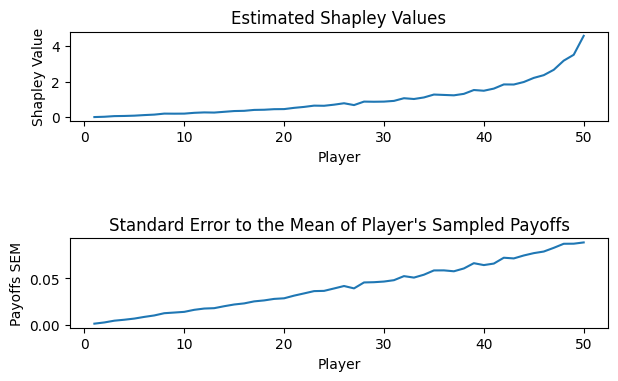

In [20]:
import matplotlib.pyplot as plt
import scipy

def estimate_shapley(N: int, samples: int):
    player_vals = get_player_vals(N)

    players = list(player_vals.keys())
    players_set = set(players)

    # store list of sampled payoffs for each player
    running_payoffs = {p: [] for p in players}
    total_payoff = max(player_vals.values())
    for _ in range(samples):
        perm = shapley.get_random_perm(players_set)
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
            running_payoffs[p].append(cur[p])
        #running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: sum(pays)/samples for (k,pays) in running_payoffs.items()}
    print(f"\nestimated shapley values: (for N = {N} players, and {samples} of permutations):")
    print(shapely_values)
    print(f"\nsum of estimated shapley values: {sum(shapely_values.values())}")

    fig, axs = plt.subplots(2)
    fig.tight_layout(pad=6.0)
    fig.set_size_inches(8, 5)
    axs[0].set_title(f"Estimated Shapley Values")
    axs[0].set_xlabel(f'Player')
    axs[0].set_ylabel(f"Shapley Value")
    axs[0].plot(players, [shapely_values[p] for p in players])

    axs[1].set_title(f"Standard Error to the Mean of Player's Sampled Payoffs")
    axs[1].set_xlabel(f'Player')
    axs[1].set_ylabel(f"Payoffs SEM")
    sems = [scipy.stats.sem(pays) for player, pays in running_payoffs.items()]
    axs[1].plot(player_vals.keys(), sems)



estimate_shapley(50, 10000)

---
## Monte Carlo Tree Search (MCTS)

testing with c = 0.0
wrote graph.pdf
wrote leaves.pdf
{3: 9223372036854775807, 2: 9223372036854775807}
3
{3: 2.554528454530239, 2: 9223372036854775807}
2
{3: 2.554528454530239, 2: 4.007732404208512}
2
{3: 2.554528454530239, 2: 3.92014941344798}
2
{2: 4.0304617821084525, 3: 2.554528454530239}
2
{2: 4.155906250868945, 3: 2.554528454530239}
2
{3: 2.554528454530239, 2: 3.78477707867743}
2
{2: 3.430029162376234, 3: 2.554528454530239}
2
{2: 3.509786690262684, 3: 2.554528454530239}
2
{3: 2.554528454530239, 2: 3.365457130139428}
2
{2: 3.2589874864328476, 3: 2.554528454530239}
2
{2: 3.2707149556245323, 3: 2.554528454530239}
2
{2: 3.2673062587508084, 3: 2.554528454530239}
2
{3: 2.554528454530239, 2: 3.24338914440399}
2
{3: 2.554528454530239, 2: 3.2260103465421857}
2
{3: 2.554528454530239, 2: 3.2397446249158186}
2
{2: 3.2921411227354596, 3: 2.554528454530239}
2
{2: 3.247442956528711, 3: 2.554528454530239}
2
{3: 2.554528454530239, 2: 3.2545961086610853}
2
{2: 3.277770126410484, 3: 2.55452845453023

/home/dan/Downloads/COURSES/Fall_2022/MAS/HW/MAS_HW/hw6/tree_search.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


wrote leaves.pdf
{2: 9223372036854775807, 3: 9223372036854775807}
2
{3: 9223372036854775807, 2: 6.71931688455628}
3
{3: 2.6035848402849107, 2: 6.904754663959725}
5
{3: 2.699130771371986, 2: 5.945707870470862}
5
{2: 5.406482415645981, 3: 2.762637289617375}
5
{2: 5.528808440371457, 3: 2.8098214510030513}
5
{2: 5.029204807084017, 3: 2.847171963209979}
5
{3: 2.87797716385439, 2: 4.59298911498403}
5
{2: 4.848960826470987, 3: 2.9041261307048503}
5
{2: 4.721579511625907, 3: 2.926800926229954}
5
{3: 2.946788730131676, 2: 4.696744878055082}
5
{3: 2.9646392538975106, 2: 4.454895354277688}
5
{2: 4.322883876822106, 3: 2.9807510356697087}
5
{3: 2.9954219153243367, 2: 4.179488859322826}
5
{2: 4.2419341122516485, 3: 3.0088801318228136}
5
{2: 4.283582282123009, 3: 3.0213043159475976}
5
{2: 4.278358961538365, 3: 3.032836809823054}
5
{2: 4.4262944975680005, 3: 3.0435928130313075}
5
{3: 3.0536668284317505, 2: 4.470984829314991}
5
{2: 4.467806889629668, 3: 3.0631373087992197}
5
{3: 3.0720700736117523, 2: 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

<Figure size 1100x850 with 0 Axes>

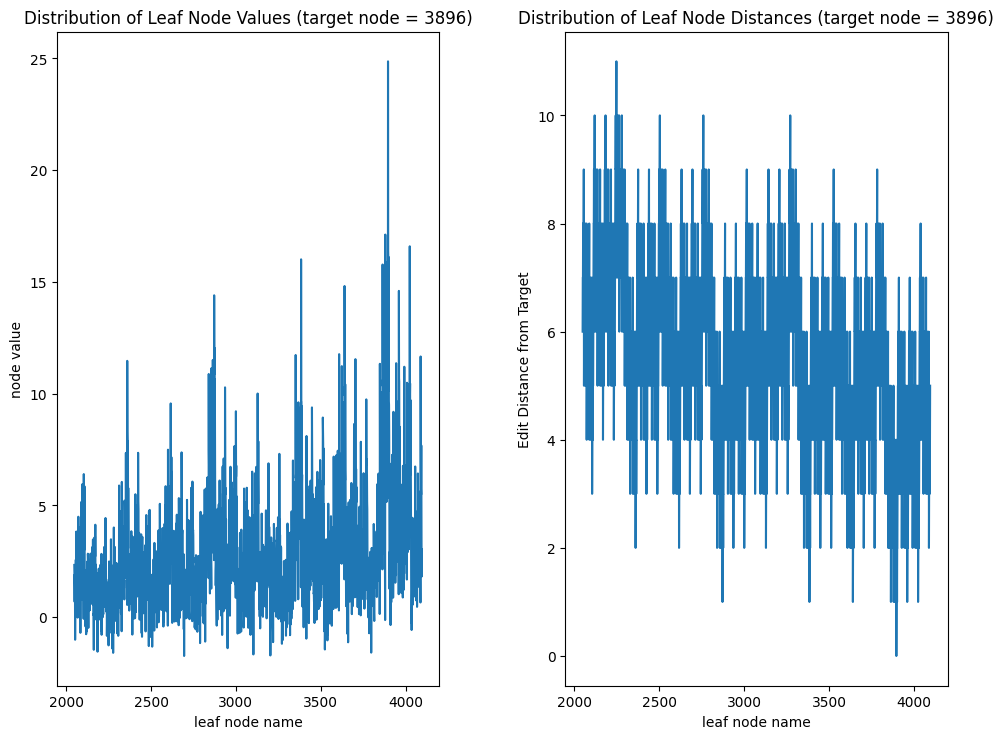

In [12]:
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import statistics
import importlib
import tree_search as ts
importlib.reload(ts)

MCTS = ts.MCTS

###### experiment params
set_seed(None)
#depth = 10
depth = 4   # depth of tree to search
B = 25      # for computing values of leaf nodes
c = 2       # hyperparam
# TODO: define computational budget
######

#mc = MCTS(depth, c=c, B=B, draw=True)

def make_graph(data, show=True, save=False, samples=None):
  plt.clf()
  fig, ax = plt.subplots(1, 1)
  ax.set_xlabel("UCB c Value")
  ax.set_ylabel("Average Payoff Received (%)")
  ax.set_title(
      f"Effect of UCB c Value on Payoffs (MCTS with Depth {depth}, Samples = {samples})"
  )
  #ax.plot(data.keys(), data.values())
  # show standard deviation as total length of error bar
  ax.errorbar(data.keys(), [sum(d)/len(d) for d in data.values()], yerr=[statistics.stdev(d)/2 for d in data.values()])
  #ax.errorbar(data.keys(), [sum(d)/len(d) for d in data.values()], yerr=[50 for d in data.values()])
  if save:
    plt.savefig("c_graphs.pdf", dpi=400)
    #print("wrote c_graphs.pdf")
  if show:
    plt.show()


data = defaultdict(list)
depth = 12
NUM_SAMPLES = 5
for c in np.linspace(0, 5, num=10):
  if c % 0.25 == 0:
    print(f"testing with c = {c}")
  for _ in range(NUM_SAMPLES):
    mc = MCTS(depth, c=c, B=B)
    tra = mc.run()
    value = mc.tree.nodes[tra[-1]]["value"]
    target_value = mc.tree.nodes[mc.target_name]["value"]
    data[c].append(100 * value / target_value)
  make_graph(data, samples=NUM_SAMPLES, show=False, save=True)
make_graph(data, samples=NUM_SAMPLES, show=True, save=True)


#tree = ts.create_tree(depth, draw=True)
#nx.draw(tree, with_labels=True, node_size=300)



# now do MCTS:
# store in each node:
# {'values': []} # (also tells you num visits)


---
## RL: SARSA and Q-Learning

### Strategy 1: SARSA with Greedification
For the first experiment, SARSA is used in combination with greedification to search for an optimal policy.

During learning, the Q-table is updated while rolling out each episode path.

Specifically we simulate `iterations` episodes (starting at a random initial position each time) and perform learning with salsa and pure greedy selection) until each episode terminates.

initial Q table:


,s,a,r,q
0,"(0, 0)",2.0,-1.0,-0.009565
1,"(0, 0)",0.0,-1.0,0.040704
2,"(0, 0)",1.0,-1.0,-0.087852
3,"(0, 0)",3.0,-1.0,0.091506
4,"(0, 1)",2.0,-1.0,-0.100777
...,...,...,...,...
319,"(8, 7)",3.0,-1.0,-0.060036
320,"(8, 8)",2.0,50.0,0.000000
321,"(8, 8)",0.0,-1.0,0.070333
322,"(8, 8)",1.0,50.0,0.000000


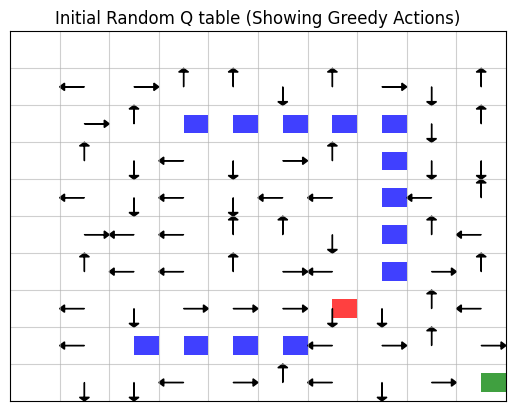

Q table (post learning):


,s,a,r,q
0,"(0, 0)",2.0,-1.0,-2.879648
1,"(0, 0)",0.0,-1.0,-2.985564
2,"(0, 0)",1.0,-1.0,-2.984675
3,"(0, 0)",3.0,-1.0,-2.985323
4,"(0, 1)",2.0,-1.0,-2.980470
...,...,...,...,...
319,"(8, 7)",3.0,-1.0,-0.060036
320,"(8, 8)",2.0,50.0,0.000000
321,"(8, 8)",0.0,-1.0,0.070333
322,"(8, 8)",1.0,50.0,0.000000


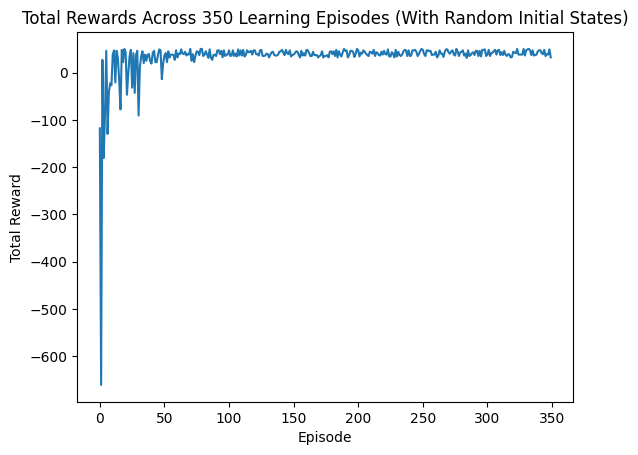

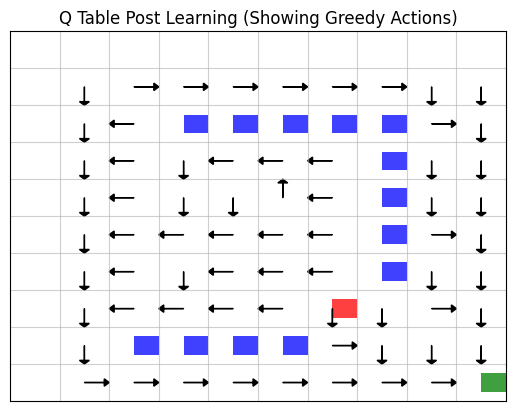

In [15]:
import importlib
import qlearn as ql
importlib.reload(ql)
sim = ql.direct_updates(sarsa=True, epsilon=0.0, iterations=350, display=display)

#### Strategy 2a: Q-Learning (Direct Updates)
Here we directly update the Q-table while rolling out each sample path.

Specifically we simulate `iterations` episodes (starting at a random initial position each time) and perform q-learning with $\epsilon$-greedy selection) until each episode terminates.

Q table (post learning):


,s,a,r,q
0,"(0, 0)",2.0,-1.0,-2.888844
1,"(0, 0)",0.0,-1.0,-2.985318
2,"(0, 0)",1.0,-1.0,-2.878611
3,"(0, 0)",3.0,-1.0,-2.985552
4,"(0, 1)",2.0,-1.0,-2.980773
...,...,...,...,...
319,"(8, 7)",3.0,-1.0,20.624811
320,"(8, 8)",2.0,50.0,0.000000
321,"(8, 8)",0.0,-1.0,-0.013534
322,"(8, 8)",1.0,50.0,0.000000


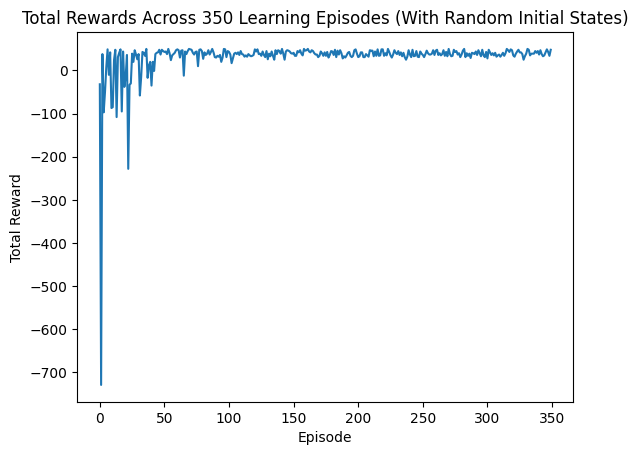

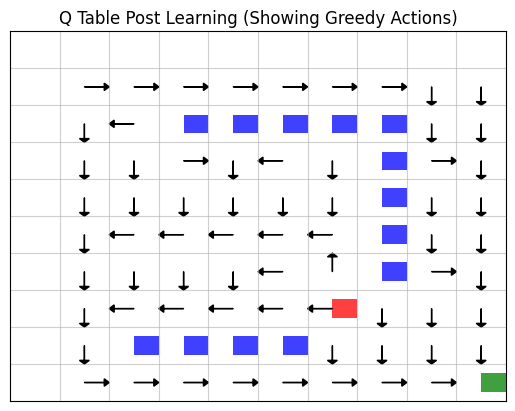

In [14]:
import importlib
import qlearn as ql
importlib.reload(ql)
sim = ql.direct_updates(iterations=350, display=display, show_initial=False)

#### Strategy 2b: Q-Learning (Replay Buffer)
Here we collect experiences by simulating episodes (without learning), and then sample from the stored experiences to perform Q-learning.

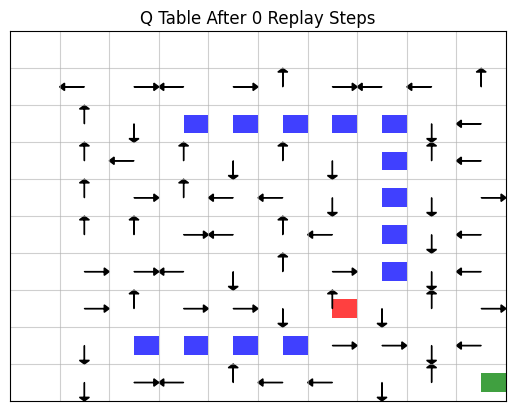

collected 5000 experiences to sample from.


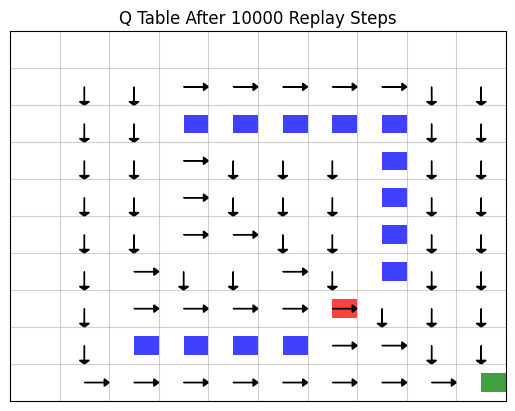

In [16]:
import importlib
import qlearn as ql
importlib.reload(ql)
ql.strategy2b()


### Discussion

**Strategy 1 and 2a**:

Comparing the graphs of rewards during learning in strategy 1 and 2a there doesn't seem to be a clear difference (at least in this implementation tested on this specific grid world example).  Both strategies appear to converge after about 100 episodes.

Note that an "episode" referes to one play through the grid world game, starting at an initial random (empty) location, and stepping through the game (with a policy defined by the q-table), until the terminal state is reached (shown in green).  The total rewards across the agents trajectory in this game is reported.

Potential future work would be to compare with more detail these two strategies, for example instead of plotting the total reward after each learning epsiode (which each start at random locations), we could sample $n=10$ (non-learning episodes) for the purposes of averaging their rewards for a more stable measure of the "fitness" of the q-table at a given moment in time.

**Strategy 2b**:

Strategy 2b is inherently harder to directly compare to the others as it doesn't train with sequential episodes, but rather with individual sampled game steps from a buffer of initial (non-learning) episode steps.  Experience replay appeared to be not be as efficient as the other strategies (at least in this implementation tested on this specific grid world example).

This strategy could be improved by interleaving experience generation, and training.  As the initial experience buffer occurs on a completely random qtable, it could be valuable to gradually replace the buffer later with experiences on a partially trained qtable as the buffer could contain more relevant state actions pairs for training.

Additionally, as the grid world map only has one terminal location (with a positive reward), its very important to the training initially that states are frequently sampled next to this location. As the q-table initially has random q values, $(s,a)$ pairs near the terminal spot need to be updated to have relevant q values before this key information can accurately percolate to the rest $(s,a)$ pairs of the q-table.